## Import necessary dependencies

In [ ]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

In [ ]:
# arguments
DATA_ROOT = "./data"
TEACHER_CHECKPOINT = "Teacher_trained_parameters.pt"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

# parameters
RANDOM_SEED = 42
IMG_SIZE = 28
N_CLASSES = 10
DROPOUT = 0.3
TEMP = 20

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Device: cuda


## Download Data - MNIST

In [ ]:
os.makedirs(DATA_ROOT, exist_ok=True)

# construct dataset
data_transforms = {'train': transforms.Compose([transforms.RandomCrop(size=IMG_SIZE, padding=2),
                                      transforms.ToTensor()]),
                   'test': transforms.Compose([transforms.ToTensor()])}

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True, transform=data_transforms['train']),
  batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True, transform=data_transforms['test']),
  batch_size=VAL_BATCH_SIZE, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Check Images

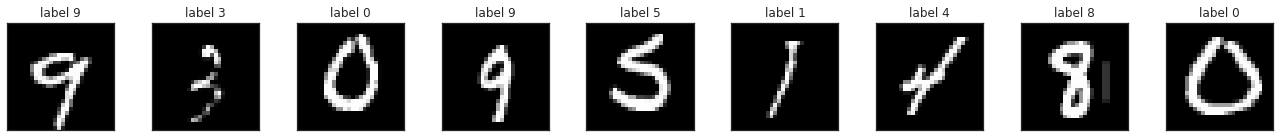

In [ ]:
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Model Define
- Cumbersome Model: two hidden layers with 1200 rectified linear units
- Small Model: two hidden layers with 800 rectified linear units
- Distilled Model: two hidden layers with 800 rectified linear units

### Utility Functions

In [ ]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    model.eval()
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=80)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for X, y_true in valid_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            # Forward pass and record loss
            y_hat, _ = model(X) 
            loss = criterion(y_hat, y_true) 
            running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        model, valid_loss = validate(valid_loader, model, valid_criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
class LargeNet(nn.Module):

    def __init__(self, n_classes, dropout_ratio=0.5, temperature=1):
        super(LargeNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs


class SmallNet(nn.Module):

    def __init__(self, n_classes, temperature=1):
        super(SmallNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs

### Cumbersome Model

==========> Teacher model
16:20:20 --- Epoch: 1	Train loss: 0.2246	Valid loss: 0.0993	Train accuracy: 95.45	Valid accuracy: 96.77
16:20:49 --- Epoch: 3	Train loss: 0.1408	Valid loss: 0.0695	Train accuracy: 97.08	Valid accuracy: 97.74
16:21:17 --- Epoch: 5	Train loss: 0.1115	Valid loss: 0.0552	Train accuracy: 97.54	Valid accuracy: 98.21
16:21:45 --- Epoch: 7	Train loss: 0.0969	Valid loss: 0.0481	Train accuracy: 97.98	Valid accuracy: 98.57
16:22:14 --- Epoch: 9	Train loss: 0.0870	Valid loss: 0.0461	Train accuracy: 98.07	Valid accuracy: 98.59
16:22:42 --- Epoch: 11	Train loss: 0.0781	Valid loss: 0.0388	Train accuracy: 98.37	Valid accuracy: 98.77
16:23:10 --- Epoch: 13	Train loss: 0.0735	Valid loss: 0.0416	Train accuracy: 98.49	Valid accuracy: 98.71
16:23:39 --- Epoch: 15	Train loss: 0.0659	Valid loss: 0.0353	Train accuracy: 98.60	Valid accuracy: 98.84
16:24:07 --- Epoch: 17	Train loss: 0.0631	Valid loss: 0.0351	Train accuracy: 98.65	Valid accuracy: 98.81
16:24:35 --- Epoch: 19	Train loss:

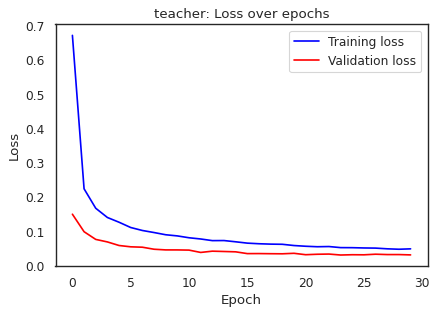


teacher model valid accuracy: 0.9899


In [ ]:
print("==========> Teacher model")

model_teacher = LargeNet(N_CLASSES, DROPOUT, TEMP).to(DEVICE)

LEARNING_RATE = 0.015
N_EPOCHS = 30
optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
params = {"dir":'.',
            "prefix": "teacher",
            "title": "teacher"
            }

model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                            train_loader, test_loader, N_EPOCHS, DEVICE, params, print_every=2)

# Save model 
torch.save(model_teacher.state_dict(), TEACHER_CHECKPOINT)

valid_acc = get_accuracy(model_teacher, test_loader, DEVICE)
print(f"\nteacher model valid accuracy: {valid_acc:.4f}")

### Small Model
Train small model base on groud Truth

=======> Student trained on Ground Truth
16:27:26 --- Epoch: 1	Train loss: 0.1921	Valid loss: 0.1052	Train accuracy: 95.24	Valid accuracy: 96.71
16:27:54 --- Epoch: 3	Train loss: 0.1177	Valid loss: 0.0772	Train accuracy: 96.73	Valid accuracy: 97.60
16:28:22 --- Epoch: 5	Train loss: 0.0893	Valid loss: 0.0581	Train accuracy: 97.44	Valid accuracy: 98.03
16:28:50 --- Epoch: 7	Train loss: 0.0750	Valid loss: 0.0487	Train accuracy: 97.86	Valid accuracy: 98.40
16:29:19 --- Epoch: 9	Train loss: 0.0660	Valid loss: 0.0447	Train accuracy: 98.22	Valid accuracy: 98.48
16:29:46 --- Epoch: 11	Train loss: 0.0563	Valid loss: 0.0396	Train accuracy: 98.41	Valid accuracy: 98.68
16:30:14 --- Epoch: 13	Train loss: 0.0507	Valid loss: 0.0452	Train accuracy: 98.42	Valid accuracy: 98.58
16:30:42 --- Epoch: 15	Train loss: 0.0482	Valid loss: 0.0346	Train accuracy: 98.63	Valid accuracy: 98.81
16:31:10 --- Epoch: 17	Train loss: 0.0437	Valid loss: 0.0389	Train accuracy: 98.80	Valid accuracy: 98.77
16:31:39 --- Epoch:

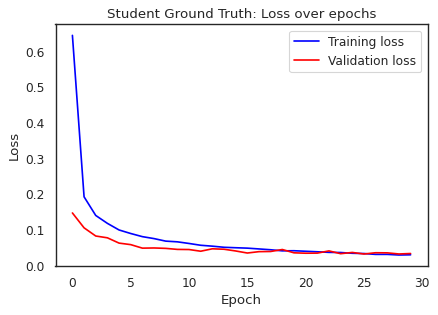


student model valid accuracy: 0.9896


In [ ]:
print(f"=======> Student trained on Ground Truth")

LEARNING_RATE = 0.015
N_EPOCHS = 30

model_s_true = SmallNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model_s_true.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s_true, optimizer, _ = training_loop(model_s_true, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, print_every=2)
torch.save(model_s_true.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

valid_acc = get_accuracy(model_s_true, test_loader, DEVICE)
print(f"\nstudent model valid accuracy: {valid_acc:.4f}")

## Distilled Model
Train distilled model base on soft labels and ground truth

=======> Student trained on Soft Label
16:34:30 --- Epoch: 1	Train loss: 0.3268	Valid loss: 0.0452	Train accuracy: 98.06	Valid accuracy: 98.51
16:35:00 --- Epoch: 3	Train loss: 0.1760	Valid loss: 0.0373	Train accuracy: 98.46	Valid accuracy: 98.78
16:35:29 --- Epoch: 5	Train loss: 0.1358	Valid loss: 0.0374	Train accuracy: 98.68	Valid accuracy: 98.75
16:35:59 --- Epoch: 7	Train loss: 0.1155	Valid loss: 0.0354	Train accuracy: 98.66	Valid accuracy: 98.81
16:36:28 --- Epoch: 9	Train loss: 0.1038	Valid loss: 0.0337	Train accuracy: 98.72	Valid accuracy: 98.88
16:36:57 --- Epoch: 11	Train loss: 0.0953	Valid loss: 0.0336	Train accuracy: 98.80	Valid accuracy: 98.86
16:37:26 --- Epoch: 13	Train loss: 0.0886	Valid loss: 0.0330	Train accuracy: 98.80	Valid accuracy: 98.90
16:37:55 --- Epoch: 15	Train loss: 0.0835	Valid loss: 0.0322	Train accuracy: 98.87	Valid accuracy: 98.98
16:38:25 --- Epoch: 17	Train loss: 0.0785	Valid loss: 0.0325	Train accuracy: 98.87	Valid accuracy: 98.96
16:38:54 --- Epoch: 1

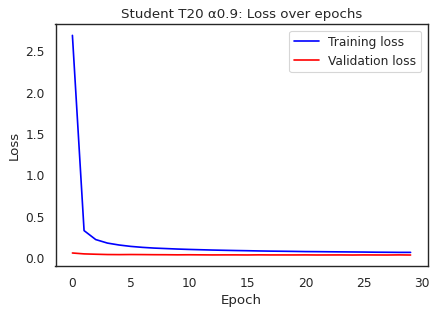


student model valid accuracy: 0.9900


In [ ]:
# Train
LEARNING_RATE = 0.015
N_EPOCHS = 30
ALPHA = 0.9

print(f"=======> Student trained on Soft Label")
model_s_soft = SmallNet(N_CLASSES, TEMP).to(DEVICE)
optimizer = torch.optim.SGD(model_s_soft.parameters(), lr=LEARNING_RATE, momentum=0.9)

valid_criterion = nn.CrossEntropyLoss()
train_criterion = SoftCrossEntropyLoss(TEMP, ALPHA)
prefix = f"student_T{TEMP}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{TEMP} α{ALPHA}"
     }

model_s_soft, optimizer, _ = training_loop(model_s_soft, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, print_every=2, teacher_model=model_teacher)
torch.save(model_s_soft.state_dict(), f"{dir_path}/{prefix}_parameters.pt")  

valid_acc = get_accuracy(model_s_soft, test_loader, DEVICE)
print(f"\nstudent model valid accuracy: {valid_acc:.4f}")